# TD-lambda

What is a good n value for n-step TD? How using a weighted combination of all n-step targets?

$\displaystyle V = V + \alpha_t \delta^{TD}_{t:t+1}(S_t) E $

In [2]:
import numpy as np

def decay_alpha(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [3]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

We write the prediction function that works for TD-lambda:

In [4]:
def td_lambda(pi, env, gamma=1.0, lambda_=0.2, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500):
    nS = env.observation_space
    
    # initialize the current estimate of the state-value function V
    # and a per-episode copy of V for offline analysis
    V = np.zeros(nS, dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # initialize the eligibility trace vector
    E = np.zeros(nS, dtype=float)
    
    # calculate all alphas at once
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);

    # loop for every episode
    for e in range(n_episodes):
        
        # set E to zero every new episode
        E.fill(0)
        
        # get the initial state
        state, done = env.reset(), False
        
        # get into the time step loop
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # interact with the environment for one step and get the experience tuple
            next_state, reward, done, _ = env.step(action)
            
            # use that experience to calculate the TD error as usual
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            
            # increment the eligibility of state by 1
            E[state] = E[state] + 1
            
            # apply the error update to all eligible states as indicated by E
            V = V + alphas[e] * td_error * E
            
            # decay E
            E = gamma * lambda_ * E
            
            state = next_state
            
        V_track[e] = V
    return V, V_track

We ran the policy evaluation algorithms on the Random Walk (RW) environment.

In [5]:
import numpy as np
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 7
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: 
            raise ValueError('Episode has terminated');
        
        if action not in [0, 1]: 
            raise ValueError('Invalid action');
        
        self._state += np.random.choice([-1, 1])
        
        reward = 0
        
        if self._state < 1: 
            self._done = True
        
        if self._state > 5: 
            self._done = True; 
            reward = 1
        
        return self._state, reward, self._done, 0  # obs, rew, done

In [6]:
random_walk = RandomWalk()

We evaluate an "all-left" policy

In [7]:
def pi(state):
    return 1

We use the n-step Temporal-Difference prediction algorithm and show the estimates over episodes

In [8]:
V_td_lambda, V_td_lambda_track = td_lambda(pi, random_walk, lambda_=0.3, n_episodes=500)

In [9]:
print(V_td_lambda)

[0.         0.13268731 0.30862386 0.53439843 0.68565556 0.85851914
 0.        ]


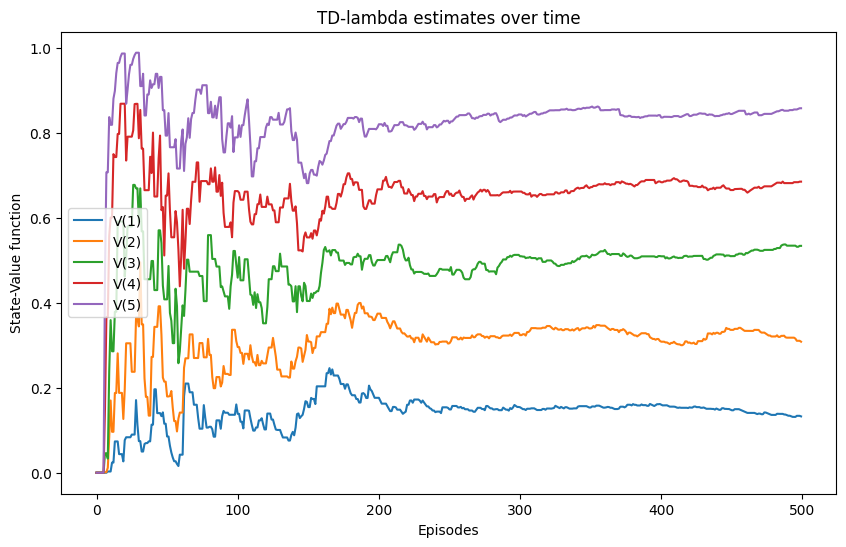

In [10]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)']
plt.figure(figsize=(10,6))
plt.plot(V_td_lambda_track[:,1:6])
plt.title('TD-lambda estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()